In [2]:
import numpy as np
import random

import matplotlib.pyplot as plt

%matplotlib inline

## 1 Thresholding

+ a. Convert the image to a gray image (5 points).
+ b. Implement a function to threshold the image (20 points) by a threshold value t.
+ c. Plot the ROC curve of that method under varying t (13 points) and submit this as an image file in sufficient quality (2 points).
+ d. sWhat is the optimal threshold t (5 points), if precision and recall are weighted equally?
+ e. Is there a better linear method to convert the RGB into the gray image, so that a sweep results in a better result (5 points)?

### 1.a Convert the image to a gray image

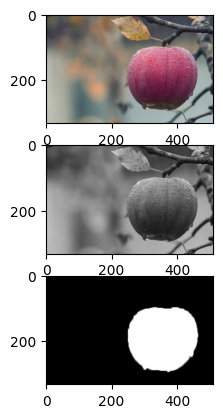

In [22]:
im1 = plt.imread('source.png')
im1_gt = plt.imread('target.png')
height, width, chs = im1.shape
im1_gray = 0.299 * im1[:, :, 0] + 0.587 * im1[:, :, 1] + 0.114 * im1[:, :, 2]
# im1_gray1 = np.mean(im1, axis=2)
fig, ax = plt.subplots(3, 1)
ax[0].imshow(im1)
ax[1].imshow(im1_gray, cmap='gray')
ax[2].imshow(im1_gt, cmap='gray')


### 1.b Implement a function to threshold the image by a threshold value t

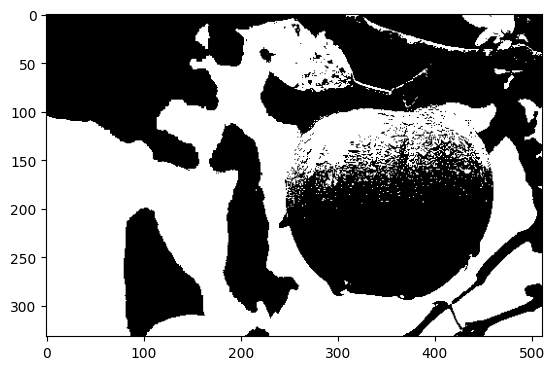

In [32]:
def threshold_image(image_gray, threshold):
    
    height, width = image_gray.shape
    image_gray = image_gray.reshape((height * width))
    thresholded = np.copy(image_gray).reshape((height * width))
    thresholded[image_gray < threshold] = 0
    thresholded[image_gray >= threshold] = 1

    return thresholded.reshape((height, width))
plt.imshow(threshold_image(im1_gray, 0.5), cmap='gray')